In [1]:
# This file is used by get_new_raw_file.py to create a report after checking a new download.  To make this work nicely,
# you should use the 'hide-input-all' nbextension and before get_new_raw_file, enable hide all, reset and clear
# all cells, save the sheet, and CLose and Halt.  

In [2]:
from math import log10, floor
def round_sig(x, sig=2):
    try:
        if abs(x)>=1:
            out =  int(round(x, sig-int(floor(log10(abs(x))))-1))
            return f"{out:,d}" # does the right thing with commas
        else: # fractional numbers
            return str(round(x, sig-int(floor(log10(abs(x))))-1))
    except:
        return x

In [3]:
#preamble to analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker
from IPython.display import Markdown as md
from time import sleep
from datetime import datetime
now = datetime.now()
today = str(datetime.today())
today = today.split()[0]

In [14]:
md("""### ATTENTION: During the COVID-19 outbreak, these reports will be performed less frequently than daily""")

### ATTENTION: During the COVID-19 outbreak, these reports will be performed less frequently than daily

In [5]:
md("Note that if you have visited this page before, you may need to clear your browser's queue for the most recent results.  For many browsers, you can just type 'Ctrl-F5'")

Note that if you have visited this page before, you may need to clear your browser's queue for the most recent results.  For many browsers, you can just type 'Ctrl-F5'

In [6]:
md(f'# FracFocus bulk download summary report for {today}')

# FracFocus bulk download summary report for 2020-03-16

In [7]:
sources = './sources/'
datefn= './out/upload_dates.csv'
currfn = 'testData'
outdir = './out/'
tempfolder = './tmp/'
webworkfolder = './website_gen/'
zfilename = 'testData'

updates = pd.read_csv(datefn)
updates['dt_added'] = pd.to_datetime(updates.date_added)
updates['days_old'] = (now - updates.dt_added).dt.days
new_upk = updates[updates.date_added==today].UploadKey.tolist()
month_upk = updates[updates.days_old<31].UploadKey.tolist()
#print(new_upk)
#md(f'### Number of new disclosures added yesterday: {len(new_upk)}')
md(f'### Number of new disclosures added recently: {len(new_upk)}')


### Number of new disclosures added recently: 0

In [8]:
# First lets make today's list

import core.Construct_set as const_set
t = const_set.Construct_set(fromScratch=False,
                            zfilename=zfilename,
                            sources=sources,
                            outdir=outdir,
                            tempfolder=tempfolder).get_full_set();
df = t.tables['allrec'].get_df()
# locat = t.get_df_location()[['UploadKey','StateName','CountyName',
#                              'iOperatorName','iUploadKey','TotalBaseWaterVolume',
#                              'FederalWell']]
locat = t.tables['event'].get_df()[['UploadKey','StateName','CountyName',
                                    'iOperatorName','iUploadKey','TotalBaseWaterVolume',
                                    'FederalWell']]
df = pd.merge(df,locat,on='iUploadKey',how='left')
todaydf = df[df.UploadKey.isin(new_upk)]
opdf = t.tables['operator'].get_df()
todaydf = pd.merge(todaydf,opdf,on='iOperatorName',how='left')

In [9]:
# md("""The following list is the most recently published fracking events. Note that these are still
# raw names and numbers and have not yet been checked for validity.""")

In [10]:
gb = todaydf.groupby(['UploadKey','StateName'],as_index=False)[['CountyName',
                                                           'OperatorName',
                                                  'TotalBaseWaterVolume','FederalWell']].first()
tmp1 = gb.groupby(['StateName','CountyName','OperatorName'],as_index=False)['UploadKey'].count()
tmp1.rename({'UploadKey':'num_new_Disclosures'},inplace=True,axis=1)
tmp2 = gb.groupby(['StateName','CountyName','OperatorName'],
          as_index=False)['TotalBaseWaterVolume'].mean()
tmp2.rename({'TotalBaseWaterVolume':'mean_Water_Used_gal'},axis=1,inplace=True)
tmp2.mean_Water_Used_gal = tmp2.mean_Water_Used_gal.map(lambda x: round_sig(x,3))
out = pd.merge(tmp1,tmp2,on=['StateName','CountyName','OperatorName'],how='left')

if len(out)>0:
    display(md("""The following list is the most recently published fracking events. Note that these are still
raw names and numbers and have not yet been checked for validity."""))
    display(out)


In [11]:
if len(gb)>0:
    gb['Water_vol_gallons'] = gb.TotalBaseWaterVolume.map(lambda x: round_sig(x,3))
    if gb.FederalWell.sum()>0:
#        display(md('# Disclosures published yesterday for fracking on US Federal lands'))
        display(md('# Disclosures published recently for fracking on US Federal lands'))
        display(gb[gb.FederalWell][['StateName','CountyName','OperatorName','Water_vol_gallons']])
    else:
        display(md('None of the disclosures above are on Federal Lands.'))


In [12]:
md(f'## Water use reported in disclosures in the past 30 days')

## Water use reported in disclosures in the past 30 days

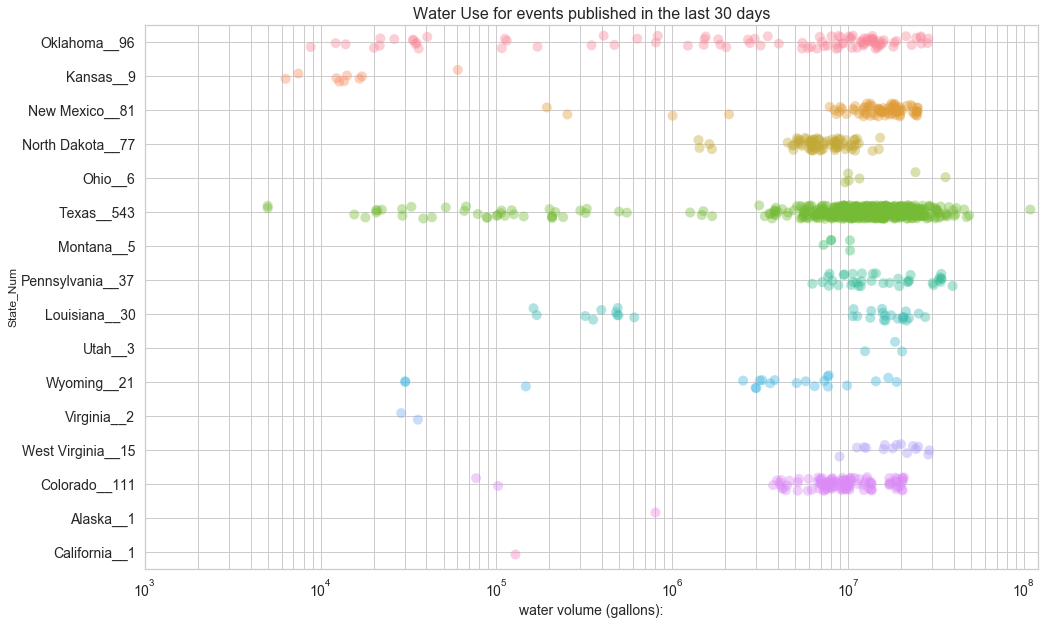

In [13]:
monthdf = df[df.UploadKey.isin(month_upk)]
# opdf = t.tables['operator'].get_df()
monthdf = pd.merge(monthdf,opdf,on='iOperatorName',how='left')
monthdf = pd.merge(monthdf,updates,on='UploadKey',how='left')
# monthdf.columns

import seaborn as sns
sns.set(style="whitegrid")
monthdf = monthdf.groupby('UploadKey',as_index=False)[['TotalBaseWaterVolume','StateName']].first()
sn = monthdf.groupby('StateName',as_index=False)['UploadKey'].count().astype('str')
sn.columns = ['StateName', 'cnt']
monthdf = pd.merge(monthdf,sn,on='StateName',how='left')
monthdf['State_Num'] = monthdf.StateName+'__'+monthdf.cnt
monthdf = monthdf.sort_values('cnt',ascending=False)
fig = plt.figure(figsize=(16,10))
ax = sns.stripplot(monthdf.TotalBaseWaterVolume,monthdf.State_Num,jitter=.2,alpha=.4,size=10)
plt.xlabel(f'water volume (gallons):',fontsize=14);
plt.title(f'Water Use for events published in the last 30 days',fontsize=16)
ax.set(xscale='log')
ax.set(xlim=(max(1000,monthdf.TotalBaseWaterVolume.min()),monthdf.TotalBaseWaterVolume.max()*1.1))
ax.grid(axis='y')
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
locmaj = matplotlib.ticker.LogLocator(base=10,subs='all') 
ax.xaxis.set_major_locator(locmaj)